In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
#Read the csv file of data
df = pd.read_csv("Data\Sex4Grades.csv")

In [3]:
#Peep head
#Total tweets
total = len(df)
print("There are {} tweets in the file".format(len(df)))
df.head(1)

There are 1496 tweets in the file


,0,1,2,3,4,5,6,7
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,en,Nigeria,False,Twitter for Android,0,0


In [4]:
#Reduce the df to relevant columns and rename, peep head
df = df[["0", "1", "3", "4", "5", "6"]]
df.columns = ["created_at", "text", "location", "verified", "source", "retweet_count"]
df.head(1)

,created_at,text,location,verified,source,retweet_count
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0


In [5]:
#Drop all rows with retweets
df = df[~df['text'].str.contains('RT')]
print("There are {} original tweets and {} retweets on file.".format(len(df), (total-len(df))))

There are 530 original tweets and 966 retweets on file.


In [6]:
df

,created_at,text,location,verified,source,retweet_count
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0
1,2019-10-09 17:26:31,Lord forgive me but any man intro himself to m...,Nigeria,False,Twitter for Android,0
3,2019-10-09 17:09:11,"Biko nu ,who is the minister of education?\r\n...","Lagos, Nigeria",False,Twitter for Android,0
4,2019-10-09 17:04:18,"@emekachukwuleta Like I said, before.. @BBCAfr...","Lagos, Nigeria",False,Twitter for Android,0
7,2019-10-09 16:32:30,A similar technology was deplored to exposing ...,NaN,False,Twitter for Android,0
...,...,...,...,...,...,...
1484,2019-09-30 13:48:58,The president of the faculty of Arts Universit...,Nigeria,False,Twitter for iPhone,3
1486,2019-09-30 13:42:14,Mr Chamberlain Etukudoh giving an opening rema...,Nigeria,False,Twitter for iPhone,2
1487,2019-09-30 13:33:36,✅ \r\nGood Afternoon Nigeria\r\nWelcome to the...,Nigeria,False,Twitter for iPhone,2
1493,2019-09-30 11:31:06,If we were to remain silent on the issues of “...,Nigeria,False,Twitter for iPhone,4


## Sentiment Analysis with textblob without cleaing

In [7]:
def get_sentiment(df):
    """
    Sentiment analysis with TextBlob. Plot will take into account only the pos and neg
    Result will be plugged back into the dataframe adding columns for sentiment.
    """
    polarity = 0
    positive = 0
    negative = 0
    neutral = 0
    sentiment = []

    for tweet in df.text:
        analysis=TextBlob(str(tweet))
        polarity += analysis.sentiment.polarity
        if (analysis.sentiment.polarity == 0):
            neutral += 1
            sentiment.append("neutral")
        elif (analysis.sentiment.polarity < 0.00):
            negative += 1
            sentiment.append("negative")
        elif (analysis.sentiment.polarity > 0.00):
            positive += 1
            sentiment.append("positive")
    
        #Show summary
    print("positive tweets are: " + str(positive))
    print("negative tweets are: " + str(negative))
    print("neutral tweets are: " + str(neutral))
    print("A total of {} was analysed.".format(positive+negative+neutral))
    
    #Plotting 1
    #Data to Plot
    labels = 'Positive', 'Negative'
    sizes = [positive, negative]
    colors = ['green', 'brown']
    explode = (0.1, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors,shadow=True, startangle=140)
    plt.axis('equal')
    plt.title("Sentiment Analysis Result")
    plt.show()

    df["sentiments"] = sentiment
    return df

positive tweets are: 178
negative tweets are: 105
neutral tweets are: 247
A total of 530 was analysed.


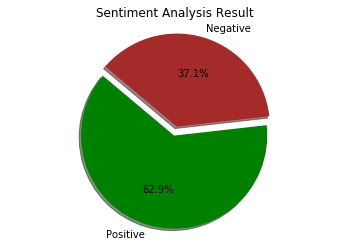

In [8]:
s4g_noClean = get_sentiment(df)

In [9]:
s4g_noClean.head(1)

,created_at,text,location,verified,source,retweet_count,sentiments
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0,negative


In [10]:
#Count words and add to the dataframe
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.head(1)

,created_at,text,location,verified,source,retweet_count,sentiments,word_count
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0,negative,16


## Data Cleaning

In [11]:
##Creating a list of stop words
stop_words = set(stopwords.words("english"))

In [12]:
#See if there are other words we want to add to drop words by looking at the freq words in the tweets by 
#dentifying the 20 most common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq
#Doesn't appear to be anyone we want to remove

the            248
to             202
of             149
#sex4grades    125
is             122
a              120
in             118
and            108
#Sex4Grades    107
I               94
for             93
you             79
are             76
this            68
be              66
that            62
on              51
will            48
not             43
lecturers       41
dtype: int64

In [13]:
#Clean up. We will take the tweets alone as a list
tweets = [line for line in s4g_noClean.text]

#Remove links
split_tweets = []
for tweet in tweets:
    #print(tweet.split())
    split_tweets.append([line for line in tweet.split() if not line.startswith("htt") ])

#Assemble the tweets back from their split state
assy_tweets = [' '.join(line) for line in split_tweets]
    
corpus = [] #variable to hold our cleaned tweets
for i in range(0, len(assy_tweets)):
    #Remove punctuations. Removes all characters NOT a-z or A-Z or 0-9 and replace with nothing ie ' ' note: carat inside the []
    text = re.sub('[^a-zA-Z + 0-9]', ' ', assy_tweets[i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation + stopwords removal
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [14]:
#Esnure we still have correct number of tweets which is 530
len(corpus)

530

In [15]:
#Plu back into df
s4g_noClean["cleaned_tweets"] = corpus
s4g_noClean.head(2)

,created_at,text,location,verified,source,retweet_count,sentiments,word_count,cleaned_tweets
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0,negative,16,buhari fight corruption fight sex4grades coz m...
1,2019-10-09 17:26:31,Lord forgive me but any man intro himself to m...,Nigeria,False,Twitter for Android,0,negative,23,lord forgive man intro pastor grabbing daughte...


In [16]:
s4g_noClean.cleaned_tweets.head()

0    buhari fight corruption fight sex4grades coz m...
1    lord forgive man intro pastor grabbing daughte...
3    biko nu minister education sex4grades wedeserv...
4    emekachukwuleta like said bbcafrica proud timi...
7    similar technology deplored exposing govumarga...
Name: cleaned_tweets, dtype: object

## Sentiment Analysis: Cleaned data

In [17]:
#Rename columns so we can use get_sentiment func
s4g_noClean = s4g_noClean.rename(columns = {'text':'noClean_tweet'})
s4g_noClean = s4g_noClean.rename(columns = {'cleaned_tweets':'text'})

In [18]:
s4g_noClean.head(2)

,created_at,noClean_tweet,location,verified,source,retweet_count,sentiments,word_count,text
0,2019-10-09 17:32:34,Buhari fight corruption but don't fight #Sex4G...,Nigeria,False,Twitter for Android,0,negative,16,buhari fight corruption fight sex4grades coz m...
1,2019-10-09 17:26:31,Lord forgive me but any man intro himself to m...,Nigeria,False,Twitter for Android,0,negative,23,lord forgive man intro pastor grabbing daughte...


positive tweets are: 168
negative tweets are: 109
neutral tweets are: 253
A total of 530 was analysed.


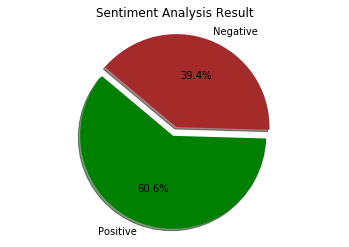

In [19]:
cleaned_Tweets = get_sentiment(s4g_noClean)

In [20]:
corpus

['buhari fight corruption fight sex4grades coz many girl unilag graduate',
 'lord forgive man intro pastor grabbing daughter wallet tightly unti',
 'biko nu minister education sex4grades wedeservebetter',
 'emekachukwuleta like said bbcafrica proud timidakolo wife g',
 'similar technology deplored exposing govumarganduje dollar corrupt allegation ngrpresident',
 'west african university today gyampo sex4grades',
 'need sex offender register sex4grades',
 'askamara jajaphd thank dont know people fail sense thing done',
 'nutritionalfacts owambes karenthebrand successcirleng hustlertrend jaggynation lagoshustlegang sexforgrades',
 'sex4grades',
 'ghana everyday different talk long cse tax increment',
 'onairnow apero aladesanmi oyekanmi discussing sex4grades listenlive download',
 'monday cold room tuesday cold induced hard work please waiting cold word',
 'atriedesp lot girl give everything good grade still excuse lecturer',
 'think time sex4grades thing end plenty suspension female tea

# # Wordcloud

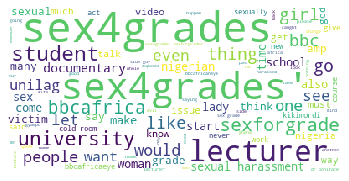

In [21]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("sex4Grade.png", dpi=900)